#Pneumonia predictoin from chest X-Rays using CNN.

##Approach

1. Data collection: Chest X-Ray images from Kaggle
2. Data Exploring: Class Distribution and doing train test spilt
3. Image Preprocessing: Pixel normalization & Image augmentation.
4. Data Modeling: Designing CNN

##0. Required Libraries

In [ ]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import shutil
from concurrent.futures import ThreadPoolExecutor

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

##1. Data collection

From [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) download the data and delete the unnecessory copies of data from the downloaded file.
Now import the data in desired form and redistribute it in Train Test and Validation sets.

In [ ]:
data_dir = '/content/drive/MyDrive/Datasets/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Function to load images and labels
def load_images(directory):
  image_paths = []
  labels = []
  for label in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(directory, label)
    for img in glob.glob(os.path.join(folder_path, '*.jpeg')):
      image_paths.append(img)
      labels.append(label)
  return np.array(image_paths), np.array(labels)

# Load images from from train, val, and test directories
train_images, train_labels = load_images(train_dir)
val_images, val_labels = load_images(val_dir)
test_images, test_labels = load_images(test_dir)

# Display the number of images in each set
print(f'Train set: {len(train_images)} images')
print(f'Validation set: {len(val_images)} images')
print(f'Test set: {len(test_images)} images')

Train set: 5216 images
Validation set: 16 images
Test set: 624 images


##2. Exploratory Data Analysis (EDA)
**bold text**

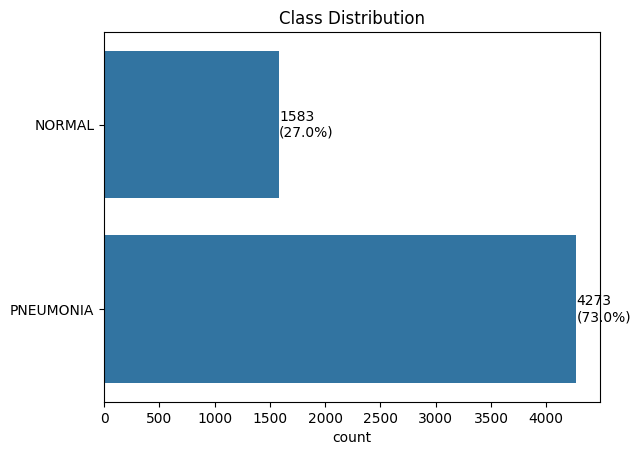

In [ ]:
# Combine all labels to visualize the distribution
all_labels = np.concatenate([train_labels, val_labels, test_labels])

# Plot class distribution
count_plt = sns.countplot(all_labels)
plt.title('Class Distribution')

# Add percentages on top of bars
total = len(all_labels)
for container in count_plt.containers:
    labels = [f'{int(c)}\n({c/total:.1%})' for c in container.datavalues]
    count_plt.bar_label(container, labels=labels)

plt.show()

##3. Redistribute the Data

In [ ]:
# Combine train and val sets to redistribute
combined_images = np.concatenate([train_images, val_images])
combined_labels = np.concatenate([train_labels, val_labels])

# Redistribute with 75% train, 15% val, 10% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    combined_images, combined_labels, test_size=0.25, stratify=combined_labels, random_state=42)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42)

print(f'Redistributed Train set: {len(train_images)} images')
print(f'Redistributed Validation set: {len(val_images)} images')
print(f'Redistributed Test set: {len(test_images)} images')

Redistributed Train set: 3924 images
Redistributed Validation set: 784 images
Redistributed Test set: 524 images


In [ ]:
new_base_dir = '/content/drive/MyDrive/Datasets/chest_xray/redistributed'

# Create train, val, and test directories
os.makedirs(os.path.join(new_base_dir, 'train', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'train', 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'val', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'val', 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'test', 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'test', 'PNEUMONIA'), exist_ok=True)

def copy_image(img_path, label, base_dir):
    label_dir = os.path.join(base_dir, label)
    shutil.copy(img_path, label_dir)

def save_images_parallel(images, labels, base_dir):
    with ThreadPoolExecutor() as executor:
        for img_path, label in zip(images, labels):
            executor.submit(copy_image, img_path, label, base_dir)


# Save train images
save_images_parallel(train_images, train_labels, os.path.join(new_base_dir, 'train'))

# Save validation images
save_images_parallel(val_images, val_labels, os.path.join(new_base_dir, 'val'))

# Save test images
save_images_parallel(test_images, test_labels, os.path.join(new_base_dir, 'test'))

# Check the number of images in each directory
print(f"Training NORMAL images: {len(os.listdir(os.path.join(new_base_dir, 'train', 'NORMAL')))}")
print(f"Training PNEUMONIA images: {len(os.listdir(os.path.join(new_base_dir, 'train', 'PNEUMONIA')))}")
print(f"Validation NORMAL images: {len(os.listdir(os.path.join(new_base_dir, 'val', 'NORMAL')))}")
print(f"Validation PNEUMONIA images: {len(os.listdir(os.path.join(new_base_dir, 'val', 'PNEUMONIA')))}")
print(f"Test NORMAL images: {len(os.listdir(os.path.join(new_base_dir, 'test', 'NORMAL')))}")
print(f"Test PNEUMONIA images: {len(os.listdir(os.path.join(new_base_dir, 'test', 'PNEUMONIA')))}")

Training NORMAL images: 1012
Training PNEUMONIA images: 2912
Validation NORMAL images: 202
Validation PNEUMONIA images: 582
Test NORMAL images: 135
Test PNEUMONIA images: 389


In [ ]:
new_base_dir = '/content/drive/MyDrive/Datasets/chest_xray/redistributed'

train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

##4. Data Augmentation

In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to [0, 1]
    rotation_range=20,     # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2,# Randomly shift images vertically
    shear_range=0.2,       # Randomly shear images
    zoom_range=0.2,        # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill in new pixels with the nearest pixel value
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

##5. Designing the Model

###Model 1

Batch size: 32

image size: (150, 150)

**Layers**

Conv2D(32, (3, 3), activation='relu') --> MaxPooling2D(pool_size=(2, 2)) --> BatchNormalization

Conv2D(64, (3, 3), activation='relu') --> MaxPooling2D(pool_size=(2, 2)) --> BatchNormalization

Conv2D(128, (3, 3), activation='relu') --> MaxPooling2D(pool_size=(2, 2)) --> BatchNormalization

Conv2D(256, (3, 3), activation='relu') --> MaxPooling2D(pool_size=(2, 2)) --> BatchNormalization

Flatten() -->
Dense(512, activation='relu') -->
Dropout(0.5) -->
Dense(1, activation='sigmoid') -->

**classification: NORMAL OR PNEUMONIA**



In [ ]:

batch_size = 32
target_size = (150, 150) # Resize images to a standard size

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

Found 3924 images belonging to 2 classes.
Found 784 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


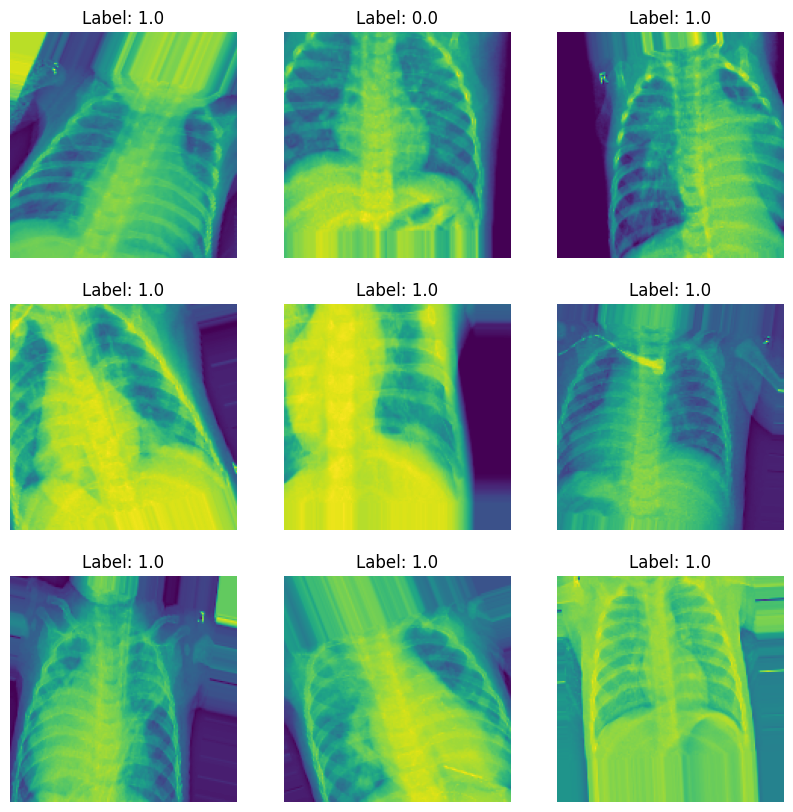

In [ ]:
# Visualize some augmented images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f'Label: {y_batch[i]}')
    plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check the GPU device name
print("GPU Device Name: ", tf.test.gpu_device_name())


Num GPUs Available:  0
GPU Device Name:  


In [ ]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Fourth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Flattening the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification (NORMAL or PNEUMONIA)

# Summary of the model
model.summary()


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
# Training the model 1
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,
    verbose=1
)


Epoch 1/20
122/122 [==============================] - 537s 4s/step - loss: 0.4511 - accuracy: 0.8512 - val_loss: 2.7442 - val_accuracy: 0.7435
Epoch 2/20
122/122 [==============================] - 52s 428ms/step - loss: 0.3192 - accuracy: 0.8798 - val_loss: 3.6151 - val_accuracy: 0.7409
Epoch 3/20
122/122 [==============================] - 53s 430ms/step - loss: 0.2748 - accuracy: 0.8913 - val_loss: 3.6124 - val_accuracy: 0.7435
Epoch 4/20
122/122 [==============================] - 52s 427ms/step - loss: 0.2302 - accuracy: 0.9070 - val_loss: 1.4337 - val_accuracy: 0.7409
Epoch 5/20
122/122 [==============================] - 52s 427ms/step - loss: 0.2183 - accuracy: 0.9121 - val_loss: 0.2355 - val_accuracy: 0.9206
Epoch 6/20
122/122 [==============================] - 52s 426ms/step - loss: 0.2157 - accuracy: 0.9186 - val_loss: 0.1442 - val_accuracy: 0.9596
Epoch 7/20
122/122 [==============================] - 52s 428ms/step - loss: 0.2159 - accuracy: 0.9214 - val_loss: 0.1375 - val_accu

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

17/17 [==============================] - 134s 8s/step - loss: 0.1405 - accuracy: 0.9523
Test accuracy: 95.23%


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples, verbose=1)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Convert probabilities to binary (0 or 1)

# Get the true labels
true_classes = test_generator.classes

print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Class labels
class_labels = list(test_generator.class_indices.keys())


 17/524 [..............................] - ETA: 2:11

524/524 [==============================] - 5s 8ms/step
Number of true labels: 524
Number of predicted labels: 524


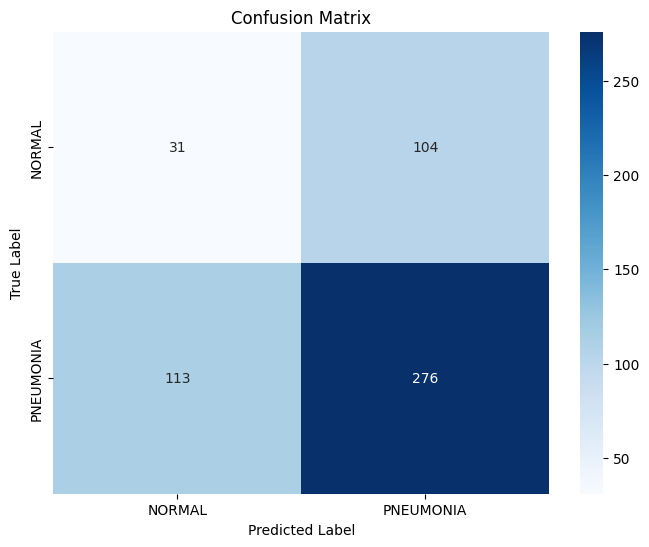

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


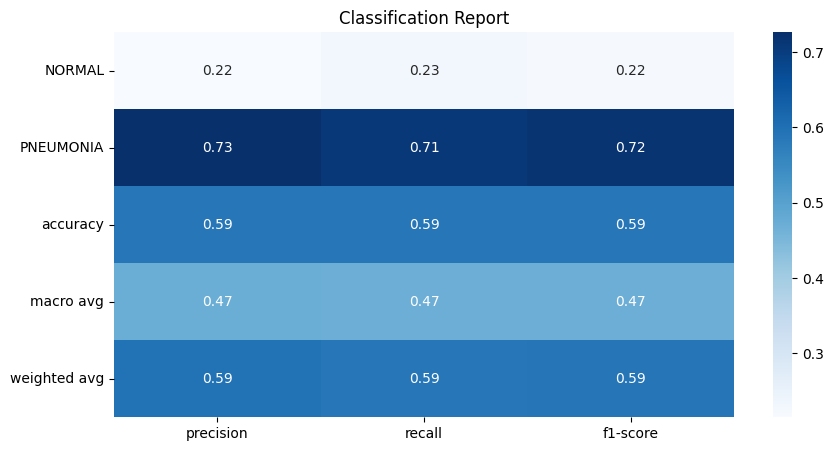

In [ ]:
import pandas as pd
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Plotting the classification report
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


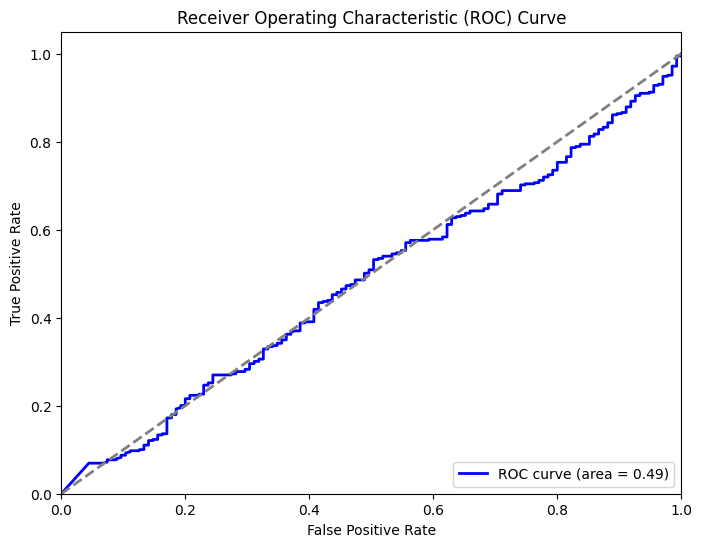

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for class 1 (PNEUMONIA)
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
